In [1]:
import torch
import numpy as np
import torch.nn as nn
import dv_processing as dv
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import timedelta
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def extract_data(events):
    return np.array([[event.timestamp(), event.x(), event.y(), event.polarity()] for event in events])

In [ ]:
file_path = "/Users/winirrr/Documents/EventBased_Project/dvSave-2024_07_11_11_26_40.aedat4"

capture = dv.io.MonoCameraRecording(file_path)
sliced_events = []

slicer = dv.EventStreamSlicer()

def slicing_callback(events: dv.EventStore):
   extracted_events = extract_data(events)
   sliced_events.append(extracted_events)

slicer.doEveryTimeInterval(timedelta(milliseconds=33), slicing_callback)

while capture.isRunning():
   events = capture.getNextEventBatch()
   if events is not None:
      slicer.accept(events)

In [3]:
file_path = "/Users/winirrr/Documents/EventBased_Project/dvSave-2024_07_11_11_26_40.aedat4"

capture = dv.io.MonoCameraRecording(file_path)
frames = []

slicer = dv.EventStreamSlicer()

# Initialize an accumulator with some resolution
accumulator = dv.Accumulator(capture.getEventResolution())

# Apply configuration, these values can be modified to taste
accumulator.setMinPotential(0.0)
accumulator.setMaxPotential(1.0)
accumulator.setNeutralPotential(0.5)
accumulator.setEventContribution(0.15)
accumulator.setDecayFunction(dv.Accumulator.Decay.EXPONENTIAL)
accumulator.setDecayParam(1e+6)
accumulator.setIgnorePolarity(False)
accumulator.setSynchronousDecay(False)

def slicing_callback(events: dv.EventStore):
   accumulator.accept(events)
   frame = accumulator.generateFrame()
   frames.append(frame.image)

slicer.doEveryTimeInterval(timedelta(milliseconds=33), slicing_callback)

while capture.isRunning():
   events = capture.getNextEventBatch()
   if events is not None:
      slicer.accept(events)

In [4]:
# Convert frames to a dataset
class EventDataset(torch.utils.data.Dataset):
    def __init__(self, frames):
        self.frames = frames

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        frame = torch.tensor(frame, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        frame = frame / 255.0
        return frame

dataset = EventDataset(frames)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
dataset = EventDataset(frames)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        img = data
        
        # Forward pass
        output = model(img)
        loss = criterion(output, img)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

Epoch 1/50: 100%|██████████| 3/3 [00:51<00:00, 17.33s/it]


Epoch [1/50], Loss: 0.0583


Epoch 2/50: 100%|██████████| 3/3 [00:48<00:00, 16.20s/it]


Epoch [2/50], Loss: 0.0520


Epoch 3/50: 100%|██████████| 3/3 [00:43<00:00, 14.49s/it]


Epoch [3/50], Loss: 0.0461


Epoch 4/50: 100%|██████████| 3/3 [00:43<00:00, 14.44s/it]


Epoch [4/50], Loss: 0.0376


Epoch 5/50: 100%|██████████| 3/3 [00:44<00:00, 14.88s/it]


Epoch [5/50], Loss: 0.0344


Epoch 6/50: 100%|██████████| 3/3 [00:42<00:00, 14.31s/it]


Epoch [6/50], Loss: 0.0293


Epoch 7/50: 100%|██████████| 3/3 [00:42<00:00, 14.11s/it]


Epoch [7/50], Loss: 0.0278


Epoch 8/50: 100%|██████████| 3/3 [00:42<00:00, 14.33s/it]


Epoch [8/50], Loss: 0.0255


Epoch 9/50: 100%|██████████| 3/3 [00:46<00:00, 15.50s/it]


Epoch [9/50], Loss: 0.0242


Epoch 10/50: 100%|██████████| 3/3 [00:43<00:00, 14.64s/it]


Epoch [10/50], Loss: 0.0230


Epoch 11/50: 100%|██████████| 3/3 [00:43<00:00, 14.53s/it]


Epoch [11/50], Loss: 0.0216


Epoch 12/50: 100%|██████████| 3/3 [00:43<00:00, 14.62s/it]


Epoch [12/50], Loss: 0.0202


Epoch 13/50: 100%|██████████| 3/3 [00:43<00:00, 14.57s/it]


Epoch [13/50], Loss: 0.0187


Epoch 14/50: 100%|██████████| 3/3 [00:44<00:00, 14.76s/it]


Epoch [14/50], Loss: 0.0170


Epoch 15/50: 100%|██████████| 3/3 [00:44<00:00, 14.73s/it]


Epoch [15/50], Loss: 0.0160


Epoch 16/50: 100%|██████████| 3/3 [00:43<00:00, 14.64s/it]


Epoch [16/50], Loss: 0.0155


Epoch 17/50: 100%|██████████| 3/3 [00:43<00:00, 14.63s/it]


Epoch [17/50], Loss: 0.0151


Epoch 18/50: 100%|██████████| 3/3 [00:42<00:00, 14.17s/it]


Epoch [18/50], Loss: 0.0148


Epoch 19/50: 100%|██████████| 3/3 [00:44<00:00, 14.69s/it]


Epoch [19/50], Loss: 0.0144


Epoch 20/50: 100%|██████████| 3/3 [00:42<00:00, 14.28s/it]


Epoch [20/50], Loss: 0.0140


Epoch 21/50: 100%|██████████| 3/3 [00:42<00:00, 14.27s/it]


Epoch [21/50], Loss: 0.0136


Epoch 22/50: 100%|██████████| 3/3 [00:44<00:00, 14.84s/it]


Epoch [22/50], Loss: 0.0133


Epoch 23/50: 100%|██████████| 3/3 [00:45<00:00, 15.08s/it]


Epoch [23/50], Loss: 0.0131


Epoch 24/50: 100%|██████████| 3/3 [00:43<00:00, 14.53s/it]


Epoch [24/50], Loss: 0.0127


Epoch 25/50: 100%|██████████| 3/3 [00:46<00:00, 15.37s/it]


Epoch [25/50], Loss: 0.0125


Epoch 26/50: 100%|██████████| 3/3 [00:45<00:00, 15.05s/it]


Epoch [26/50], Loss: 0.0122


Epoch 27/50: 100%|██████████| 3/3 [00:44<00:00, 14.94s/it]


Epoch [27/50], Loss: 0.0120


Epoch 28/50: 100%|██████████| 3/3 [01:00<00:00, 20.17s/it]


Epoch [28/50], Loss: 0.0118


Epoch 29/50: 100%|██████████| 3/3 [00:52<00:00, 17.44s/it]


Epoch [29/50], Loss: 0.0116


Epoch 30/50: 100%|██████████| 3/3 [00:45<00:00, 15.26s/it]


Epoch [30/50], Loss: 0.0115


Epoch 31/50: 100%|██████████| 3/3 [00:42<00:00, 14.33s/it]


Epoch [31/50], Loss: 0.0114


Epoch 32/50: 100%|██████████| 3/3 [00:43<00:00, 14.51s/it]


Epoch [32/50], Loss: 0.0111


Epoch 33/50: 100%|██████████| 3/3 [00:42<00:00, 14.19s/it]


Epoch [33/50], Loss: 0.0111


Epoch 34/50: 100%|██████████| 3/3 [00:43<00:00, 14.39s/it]


Epoch [34/50], Loss: 0.0109


Epoch 35/50: 100%|██████████| 3/3 [00:43<00:00, 14.50s/it]


Epoch [35/50], Loss: 0.0108


Epoch 36/50: 100%|██████████| 3/3 [00:43<00:00, 14.44s/it]


Epoch [36/50], Loss: 0.0107


Epoch 37/50: 100%|██████████| 3/3 [00:43<00:00, 14.39s/it]


Epoch [37/50], Loss: 0.0106


Epoch 38/50: 100%|██████████| 3/3 [00:46<00:00, 15.41s/it]


Epoch [38/50], Loss: 0.0106


Epoch 39/50: 100%|██████████| 3/3 [00:50<00:00, 16.98s/it]


Epoch [39/50], Loss: 0.0107


Epoch 40/50: 100%|██████████| 3/3 [00:49<00:00, 16.60s/it]


Epoch [40/50], Loss: 0.0105


Epoch 41/50: 100%|██████████| 3/3 [00:43<00:00, 14.36s/it]


Epoch [41/50], Loss: 0.0105


Epoch 42/50: 100%|██████████| 3/3 [00:44<00:00, 14.83s/it]


Epoch [42/50], Loss: 0.0103


Epoch 43/50: 100%|██████████| 3/3 [00:44<00:00, 14.94s/it]


Epoch [43/50], Loss: 0.0103


Epoch 44/50: 100%|██████████| 3/3 [00:43<00:00, 14.37s/it]


Epoch [44/50], Loss: 0.0102


Epoch 45/50: 100%|██████████| 3/3 [00:43<00:00, 14.38s/it]


Epoch [45/50], Loss: 0.0102


Epoch 46/50: 100%|██████████| 3/3 [00:44<00:00, 14.72s/it]


Epoch [46/50], Loss: 0.0100


Epoch 47/50: 100%|██████████| 3/3 [00:42<00:00, 14.19s/it]


Epoch [47/50], Loss: 0.0100


Epoch 48/50: 100%|██████████| 3/3 [00:43<00:00, 14.61s/it]


Epoch [48/50], Loss: 0.0100


Epoch 49/50: 100%|██████████| 3/3 [00:44<00:00, 14.87s/it]


Epoch [49/50], Loss: 0.0099


Epoch 50/50: 100%|██████████| 3/3 [00:45<00:00, 15.14s/it]

Epoch [50/50], Loss: 0.0099


In [6]:
# Visualization function
def visualize(original, reconstructed):
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axes[0, i].imshow(original[i].squeeze(0), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].squeeze(0), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle('Original and Reconstructed Images')
    plt.show()

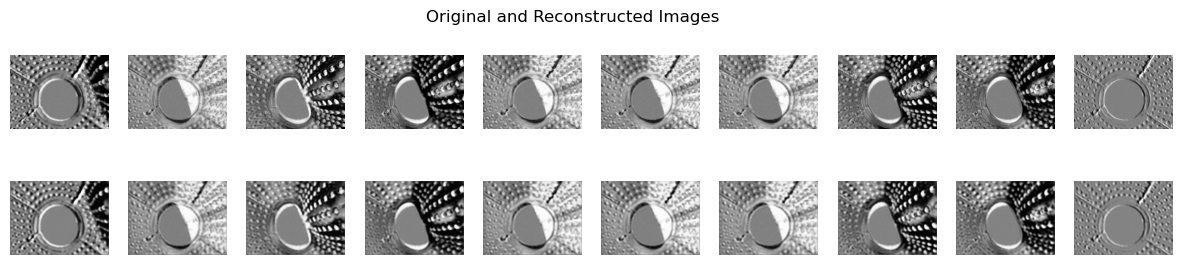

In [7]:
model.eval()

# Visualize the results
with torch.no_grad():
    sample_data = next(iter(dataloader))
    reconstructed = model(sample_data)
    visualize(sample_data.numpy(), reconstructed.numpy())

In [8]:
len(reconstructed)

32

In [14]:
sample_image = sample_data[1].squeeze(0).numpy()
reconstructed_image = reconstructed[1].squeeze(0).numpy()

(-0.5, 639.5, 479.5, -0.5)

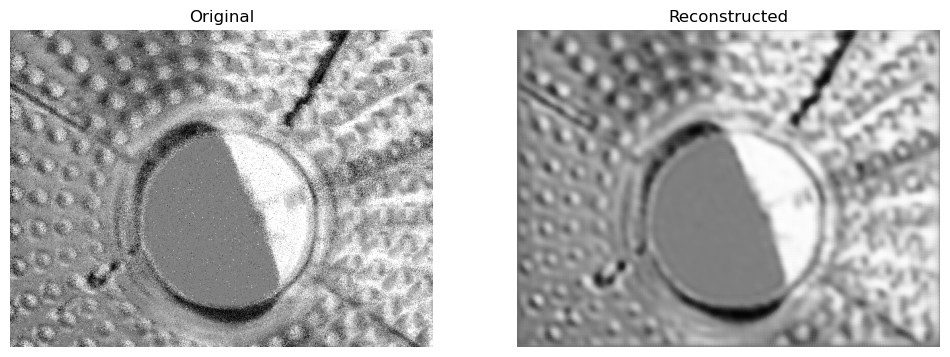

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].imshow(sample_image, cmap="gray")
ax[0].set_title("Original")
ax[0].axis('off')

ax[1].imshow(reconstructed_image, cmap="gray")
ax[1].set_title("Reconstructed")
ax[1].axis('off')

In [1]:
mat = np.random()

NameError: name 'np' is not defined